In [3]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import numpy as np
import random 
from random import sample
from networkx.algorithms import community
import time

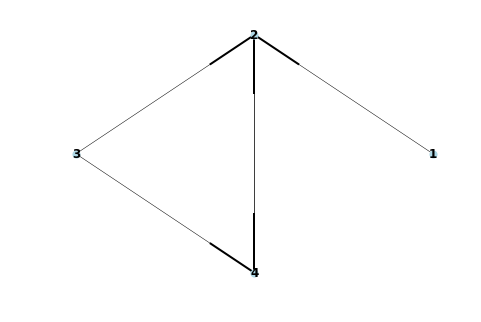

In [3]:
#create basic directed graph for testing function
#bold indicates the direction (move from not bold side to bold side)
G = nx.DiGraph()
G.add_nodes_from([1, 2,3, 4])
G.add_edges_from([(1, 2), (4, 2), (3, 2), (3, 4), (2, 4)])

options = {
 'node_color': "lightblue",
 'node_size': 50,
 'width': 0.5}
#plt.figure(figsize=(8, 6), dpi=80)
nx.draw_shell(G, with_labels=True, font_weight='bold', **options)
plt.show()

#create transition matrix
pagerank = nx.google_matrix(G)
transitions = [
        [ 0, 1, 0, 0],
        [ 0, 0, 0, 1],
        [ 0, 0.5, 0, 0.5],
        [ 0, 1, 0, 0]
              ]
communities = {1:[1], 2:[2, 3, 4], 3:[2, 3, 4], 4:[2, 3, 4]}

In [4]:
#create benchmark graph for community detection
n = 250
tau1 = 3
tau2 = 1.5
mu = 0.1
G = community.LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=5,min_community=20, seed=10)

In [5]:
#get the communities
communities = {v:list(G.nodes[v]['community']) for v in G}

In [6]:
#get pagerank transition matrix for G
pg = nx.google_matrix(G)
pg

matrix([[ 0.0006,  0.0006,  0.0006, ...,  0.0006,  0.0006,  0.0006],
        [ 0.0006,  0.0006,  0.0006, ...,  0.0006,  0.0006,  0.0006],
        [ 0.0006,  0.0006,  0.0006, ...,  0.0006,  0.0006,  0.0006],
        ..., 
        [ 0.0006,  0.0006,  0.0006, ...,  0.0006,  0.0006,  0.0006],
        [ 0.0006,  0.0006,  0.0006, ...,  0.0006,  0.0006,  0.0006],
        [ 0.0006,  0.0006,  0.0006, ...,  0.0006,  0.0006,  0.0006]])

In [7]:
def out_transition_freq(n, matrix, community):
    #start = time.time()
    out = []
    nodes = np.arange(n)
    for i in nodes:
        if i not in community:
            out.append(i)
    ixgrid = np.ix_(community, out)
    m = matrix[ixgrid]
    #end = time.time()
    return m.sum()

In [1]:
#I timed each of these (calculating in transitions and out transitions separately vs all together). 
#the get_transitions_freq function is faster than the combo of in_transitions_freq and out_transitions_freq
def within_transitions(matrix, community):
    ixgrid = np.ix_(community, community)
    m = matrix[ixgrid]
    s = m.sum()
    return s

def out_transitions(matrix, community):
    within = within_transitions(matrix, community)

    #start = time.time()
    ixgrid = np.ix_(community)
    m = matrix[ixgrid, :]
    out_transitions = m.sum()
    #end = time.time()
    return out_transitions - within
    
def in_transitions(matrix, community):
    within = within_transitions(matrix, community)
    
    ixgrid = np.ix_(community)
    m_in = matrix[:, ixgrid]
    in_transitions = m_in.sum()
    return in_transitions - within

def ratio(matrix, community):
    o = out_transitions(matrix, community)
    i = in_transitions(matrix, community)
    return i/o

def classify(ratio, bounds):
    '''bounds = [upper bound for source, lower bound for sink]'''
    if ratio < bounds[0]:
        return "sink"
    elif ratio > bounds[1]:
        return "source"
    else:
        return "manager"

def get_transition_freq(matrix, community):
    '''matrix is a numpy matrix describing the transition matrix for a graph. communities is a list of nodes'''
    #A_{ij}: represents frequency of transition from node i to node j

    #sums entries of square matrix that represents all transitions within the community and from community outward
    #np.ix_ allows easier subsetting by creating n-d meshgrid for the matrix
    ixgrid = np.ix_(community)
    m = matrix[ixgrid, :]
    comm_out_transitions = m.sum()
    
    m_in = matrix[:, ixgrid]
    comm_in_transitions = m_in.sum()
    
    #sums entries of square matrix that represents all transitions within the community only
    ixgrid_c = np.ix_(community, community)
    m_c = matrix[ixgrid_c]
    within_transition = m_c.sum()
    
    #subtract total community transitions from within community transitions
    out_transition = comm_out_transitions - within_transition
    in_transition = comm_in_transitions - within_transition
    
    ratio = in_transition/out_transition
    return (in_transition, out_transition, ratio)

In [9]:
testm = np.matrix([[0, 1, 0, 0],
                   [1, 0, 0, 2],
                   [1, 0, 1, 0],
                   [0, 2, 0, 3]])

testcomm = [1, 3]

out_transitions(testm, testcomm)
#classify(0.5, [0.3, 0.6])

1

In [17]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

def get_medoids(comm_coords):
    '''takes in community coordinates (converts to np matrix in function, so pd dataframe is fine) w one column for 
    x coords and other for y'''
    data = comm_coords.as_matrix()
    #get distance matrix using euclidean distance
    D = pairwise_distances(data, metric='euclidean')
    #take column sum and get argmin
    medoid_index = np.argmin(D.sum(axis=0))
    #get xy coordinate of medoid
    return data[medoid_index]

def within_transitions(matrix, community):
    ixgrid = np.ix_(community, community)
    m = matrix[ixgrid]
    s = m.sum()
    return s

def out_transitions(matrix, community):
    within = within_transitions(matrix, community)

    #start = time.time()
    ixgrid = np.ix_(community)
    m = matrix[ixgrid, :]
    out_transitions = m.sum()
    #end = time.time()
    return out_transitions - within
    

array([2, 2])

array([[  0.        ,   1.41421356,  12.72792206],
       [  1.41421356,   0.        ,  11.3137085 ],
       [ 12.72792206,  11.3137085 ,   0.        ]])